In [ ]:
%%bash 

pip install -U numpy

In [1]:
import skimage
import numpy as np
from skimage import io, transform
import os
import shutil
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import urllib2
from urllib2 import urlopen, Request

import sys
sys.path.append("models/research/")
sys.path.append("models/research/slim/")

from google.protobuf import text_format
from object_detection.builders import model_builder
from object_detection.meta_architectures import faster_rcnn_meta_arch


from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import io

from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict


%matplotlib inline

Before opening the Jupyter Notebook make sure you have cloned the `models` folder into the repository root directory and run the following from the root diretory to install the TensorFlow API

```bash
git clone https://github.com/tensorflow/models.git
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
cd ..
cd ..
```

In [4]:
%%bash 

apt-get install protobuf-compiler
Y


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libprotobuf9v5 libprotoc9v5
The following NEW packages will be installed:
  libprotobuf9v5 libprotoc9v5 protobuf-compiler
0 upgraded, 3 newly installed, 0 to remove and 12 not upgraded.
Need to get 620 kB of archives.
After this operation, 2321 kB of additional disk space will be used.
Do you want to continue? [Y/n] Get:1 http://archive.ubuntu.com/ubuntu xenial/main amd64 libprotobuf9v5 amd64 2.6.1-1.3 [326 kB]
Get:2 http://archive.ubuntu.com/ubuntu xenial/main amd64 libprotoc9v5 amd64 2.6.1-1.3 [273 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial/main amd64 protobuf-compiler amd64 2.6.1-1.3 [20.4 kB]
Fetched 620 kB in 0s (636 kB/s)
Selecting previously unselected package libprotobuf9v5:amd64.
(Reading database ... 49470 files and directories currently installed.)
Preparing to unpack .../libprotobuf9v5_2.6.1-1.3_amd64.deb ...
Unpacking libprotobuf9v

debconf: delaying package configuration, since apt-utils is not installed


In [5]:
%%bash

git clone https://github.com/tensorflow/models
cd models/research
protoc object_detection/protos/*.proto --python_out=.
cd .. 
cd .. 
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

Cloning into 'models'...


Set Up Path Directories
--------------------------

In [9]:
root = os.getcwd()
imagePath = os.path.join(root, 'images')
labelsPath = os.path.join(root, 'labels')
linksPath = os.path.join(imagePath, 'imageLinks')
trainPath = os.path.join(imagePath, 'train')
testPath = os.path.join(imagePath, 'test')

Create Dataset
----------------

Some very large detection datasets such as [Pascal](http://www.cs.stanford.edu/~roozbeh/pascal-context/) and [COCO](http://cocodataset.org/#home) exist already but if you want to train a custom object detection class you simply need to create and label your own dataset.
For my dataset I decided to collect images of chess pieces.  I started only using white and black pawns but I’m hoping to include all chess pieces in the future.  Since I was gathering all my images from search engines I decided to make a list of links in a text file which later can be downloaded using a script and scikit image. 

The labels for the pawn detector are all together in the labels dir and will be moved accordingly with their associated images.  If you plan on creating your own dataset make your own text file of links in the images/imageLinks folder and set copyLabels to False.

In [10]:
# A simple link checker that will make sure link to image is valid
def check(url):
    try:
        f= urlopen(url)
    except urllib2.URLError :
            return False
    return True

In [11]:
listing = os.listdir(linksPath) 
listing

['wBishop.txt',
 'bPawn.txt',
 'bCastle.txt',
 'wQueen.txt',
 'bQueen.txt',
 'wPawn.txt',
 'wKing.txt',
 'wCastle.txt',
 'bKnight.txt',
 'bKing.txt',
 'bBishop.txt',
 'wKnight.txt']

In [12]:
'''
This function will download and resize all images in the
imageLinks folder and will split into train and test folders
with their associated label.

It is your responsibility to ensure that use of copyrighted images
accessed in connection with this script complies with any license
restrictions that may apply.
'''


copyLabels = True
trainPercent = 0.85

listing = os.listdir(linksPath) 
print listing
for classes in listing:
    os.chdir(linksPath)
    text = open(classes, 'r')
    links = text.readlines()
    links = [i.strip() for i in links]
    
    cut = int(np.floor(len(links)*trainPercent))
    
    for i in range(cut):
        os.chdir(trainPath)
        if check(links[i]):
            image = skimage.io.imread(links[i])
            image = skimage.transform.resize(image, [300,300])
            skimage.io.imsave(classes[:-4]+str(i)+'.jpg', image)
            if copyLabels:
                label = classes[:-4]+str(i)+'.xml'
                shutil.copyfile(labelsPath+'/'+label,trainPath+'/'+label) 
        
    for i in range(cut,len(links)):
        os.chdir(testPath)
        if check(links[i]):
            image = skimage.io.imread(links[i])
            image = skimage.transform.resize(image, [300,300])
            skimage.io.imsave(classes[:-4]+str(i)+'.jpg', image)
            if copyLabels:
                label = classes[:-4]+str(i)+'.xml'
                shutil.copyfile(labelsPath+'/'+label,testPath+'/'+label) 
        

['wBishop.txt', 'bPawn.txt', 'bCastle.txt', 'wQueen.txt', 'bQueen.txt', 'wPawn.txt', 'wKing.txt', 'wCastle.txt', 'bKnight.txt', 'bKing.txt', 'bBishop.txt', 'wKnight.txt']


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Examples of the files and images below

In [17]:
testImage = skimage.io.imread("http://upload.wikimedia.org/wikipedia/commons/1/1f/Chess_pawn_0968.jpg")
print testImage.shape
testImage 

(2982, 2093, 3)


array([[[  6,   7,   2],
        [  6,   7,   2],
        [  6,   7,   2],
        ..., 
        [ 14,  14,  12],
        [ 14,  14,  12],
        [ 13,  13,  11]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ..., 
        [ 15,  15,  13],
        [ 15,  15,  13],
        [ 15,  15,  13]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ..., 
        [ 16,  16,  14],
        [ 16,  16,  14],
        [ 16,  16,  14]],

       ..., 
       [[169,  96,  28],
        [170,  97,  29],
        [170,  97,  29],
        ..., 
        [210, 138,  38],
        [209, 137,  37],
        [209, 137,  37]],

       [[170,  97,  29],
        [170,  97,  29],
        [171,  98,  30],
        ..., 
        [211, 139,  39],
        [209, 137,  37],
        [208, 136,  36]],

       [[170,  97,  29],
        [171,  98,  30],
        [171,  98,  30],
        ..., 
        [212, 140,  40],
        [209, 137,  37],
        [208, 136,

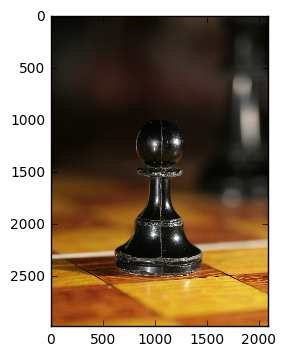

In [26]:
plt.imshow(testImage);

In [34]:
os.chdir(root)

In [35]:
%%bash 
 
cat labels/bPawn0.xml


<annotation>
	<folder>bPawn</folder>
	<filename>bPawn0.jpg</filename>
	<path>/home/justin/Desktop/chess/bPawn/bPawn0.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>300</width>
		<height>300</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bPawn</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>88</xmin>
			<ymin>100</ymin>
			<xmax>209</xmax>
			<ymax>253</ymax>
		</bndbox>
	</object>
</annotation>


Convert XML Labels to CSV
-----------------------------

In [38]:
glob.glob(trainPath + '/*.xml')

['/notebook/code/cust/images/train/wPawn30.xml',
 '/notebook/code/cust/images/train/bPawn34.xml',
 '/notebook/code/cust/images/train/wPawn48.xml',
 '/notebook/code/cust/images/train/bPawn47.xml',
 '/notebook/code/cust/images/train/wPawn31.xml',
 '/notebook/code/cust/images/train/bPawn17.xml',
 '/notebook/code/cust/images/train/bPawn58.xml',
 '/notebook/code/cust/images/train/bPawn1.xml',
 '/notebook/code/cust/images/train/bPawn40.xml',
 '/notebook/code/cust/images/train/bPawn44.xml',
 '/notebook/code/cust/images/train/bPawn64.xml',
 '/notebook/code/cust/images/train/bPawn35.xml',
 '/notebook/code/cust/images/train/wPawn59.xml',
 '/notebook/code/cust/images/train/wPawn45.xml',
 '/notebook/code/cust/images/train/wPawn34.xml',
 '/notebook/code/cust/images/train/wPawn41.xml',
 '/notebook/code/cust/images/train/wPawn69.xml',
 '/notebook/code/cust/images/train/bPawn25.xml',
 '/notebook/code/cust/images/train/wPawn12.xml',
 '/notebook/code/cust/images/train/wPawn38.xml',
 '/notebook/code/cust

In [50]:
# Modified From:
# https://github.comr/datitran/raccoon_dataset/blob/master/xml_to_csv.py

os.chdir(root)

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    
    for i in [trainPath, testPath]:
        image_path = i
        folder = os.path.basename(os.path.normpath(i))
        xml_df = xml_to_csv(image_path)
        currentPath = 'data/'+folder+'.csv'
        print(currentPath)
        xml_df.to_csv(currentPath, index=None)
        print('Successfully converted xml to csv.')
    
main()

data/train.csv
Successfully converted xml to csv.
data/test.csv
Successfully converted xml to csv.


In [51]:
pd.read_csv('data/train.csv')

filename  width  height  class  xmin  ymin  xmax  ymax
0    wPawn30.jpg    300     300  wPawn   200   120   269   211
1    bPawn34.jpg    300     300  bPawn    83    76   157   249
2    wPawn48.jpg    300     300  wPawn    78   174   102   245
3    wPawn48.jpg    300     300  bPawn    37   134    58   203
4    bPawn47.jpg    300     300  bPawn   151   151   203   262
5    wPawn31.jpg    300     300  wPawn   151    33   221   221
6    wPawn31.jpg    300     300  bPawn   233     6   287   159
7    wPawn31.jpg    300     300  bPawn   148     9   204   166
8    bPawn17.jpg    300     300  bPawn     1   122    47   274
9    bPawn17.jpg    300     300  bPawn   123   122   188   271
10   bPawn17.jpg    300     300  bPawn   252   119   300   265
11   bPawn58.jpg    300     300  bPawn   154   156   211   278
12   bPawn58.jpg    300     300  wPawn    13   141    43   198
13   bPawn58.jpg    300     300  wPawn    48   139    77   196
14   bPawn58.jpg    300     300  wPawn    82   138   113   196
15   bPawn58.jpg    300     300  wPawn   118   141   147   196
16   bPawn58.jpg    300     300  wPawn   151   140   177   195
17   bPawn58.jpg    300     300  wPawn   194   140   218   197
18   bPawn58.jpg    300     300  wPawn   222   139   253   195
19   bPawn58.jpg    300     300  wPawn   259   139   288   196
20    bPawn1.jpg    300     300  bPawn    22    60   126   252
21    bPawn1.jpg    300     300  wPawn   175    58   279   252
22   bPawn40.jpg    300     300  bPawn   112    59   133   129
23   bPawn40.jpg    300     300  bPawn   159    64   181   130
24   bPawn40.jpg    300     300  bPawn   179   107   205   180
25   bPawn40.jpg    300     300  bPawn   250    74   273   144
26   bPawn40.jpg    300     300  wPawn     1   152    11   224
27   bPawn40.jpg    300     300  wPawn    34   151    62   229
28   bPawn40.jpg    300     300  wPawn    97   136   123   211
29   bPawn40.jpg    300     300  wPawn   126   164   152   241
..           ...    ...     ...    ...   ...   ...   ...   ...
364  wPawn42.jpg    300     300  wPawn    78    88   228   298
365  bPawn56.jpg    300     300  bPawn   102   118   151   251
366  bPawn56.jpg    300     300  bPawn    61    50    95   153
367  bPawn56.jpg    300     300  bPawn   241    77   275   181
368  bPawn56.jpg    300     300  wPawn     8    85    50   199
369  bPawn56.jpg    300     300  wPawn   208    63   242   161
370  bPawn56.jpg    300     300  wPawn    26   153    80   293
371   wPawn8.jpg    300     300  wPawn   120   136   177   259
372  bPawn51.jpg    300     300  bPawn   160    92   207   216
373  bPawn51.jpg    300     300  bPawn   121    33   144    99
374  bPawn51.jpg    300     300  bPawn   272    48   300   132
375  bPawn51.jpg    300     300  bPawn   257    40   283   110
376  bPawn51.jpg    300     300  bPawn   247    28   267    85
377  bPawn51.jpg    300     300  wPawn    93    95   138   217
378  bPawn51.jpg    300     300  wPawn   210    40   240   112
379  bPawn51.jpg    300     300  wPawn     1    45    34   128
380  bPawn51.jpg    300     300  wPawn    72    31   109   108
381  wPawn54.jpg    300     300  wPawn    54     5   195   295
382  wPawn54.jpg    300     300  bPawn   175     9   296   275
383  bPawn54.jpg    300     300  bPawn    51   183    93   287
384  bPawn54.jpg    300     300  wPawn     1   180    34   273
385  bPawn69.jpg    300     300  bPawn   173    43   238   187
386  bPawn69.jpg    300     300  wPawn    20    57    86   208
387  bPawn69.jpg    300     300  wPawn    86     3   143   143
388  bPawn69.jpg    300     300  wPawn   118   101   189   260
389  bPawn69.jpg    300     300  wPawn   266    73   300   225
390  bPawn69.jpg    300     300  wPawn   225     1   287   118
391  bPawn69.jpg    300     300  wPawn   212   143   290   282
392  bPawn69.jpg    300     300  wPawn    44   168   111   281
393  bPawn11.jpg    300     300  bPawn    83    20   215   274

[394 rows x 8 columns]

Create TF Record
------------------------------------------------------

When training models with TensorFlow using [tfrecords](http://goo.gl/oEyYyR) files help optimize your data feed.  We can generate a tfrecord using code adapted from this [raccoon detector](https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py).

### install object detection api

In [ ]:
%%bash 

apt-get install protobug-compiler

cd /opt
git clone https://github.com/tensorflow/models
cd models/research
protoc object_detection/protos/*.proto --python_out=.
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

In [4]:


# Add more class labels as needed, make sure to start at 1
def class_text_to_int(row_label):
    if row_label == 'wPawn':
        return 1
    if row_label == 'bPawn':
        return 2 
    else:
        None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

for i in ['test', 'train']:
    writer = tf.python_io.TFRecordWriter(i+'.record')
    path = os.path.join(os.getcwd(), 'images/'+i)
    examples = pd.read_csv('data/'+i+'.csv')
    grouped = split(examples, 'filename')
    for group in grouped:
        print(group)
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('Successfully created the '+i+ ' TFRecords')




data(filename='bPawn77.jpg', object=       filename  width  height  class  xmin  ymin  xmax  ymax
32  bPawn77.jpg    300     300  bPawn   148     1   172    60
33  bPawn77.jpg    300     300  wPawn   218    69   253   160
34  bPawn77.jpg    300     300  wPawn   137    69   172   159
35  bPawn77.jpg    300     300  bPawn   273    10   300    88)
data(filename='bPawn79.jpg', object=      filename  width  height  class  xmin  ymin  xmax  ymax
1  bPawn79.jpg    300     300  bPawn    42   139    84   257
2  bPawn79.jpg    300     300  wPawn    66   123    96   210
3  bPawn79.jpg    300     300  wPawn   133   121   168   212
4  bPawn79.jpg    300     300  wPawn   190   122   226   215
5  bPawn79.jpg    300     300  wPawn   265   118   300   214)
data(filename='wPawn76.jpg', object=       filename  width  height  class  xmin  ymin  xmax  ymax
59  wPawn76.jpg    300     300  wPawn   117   105   180   299)
data(filename='wPawn80.jpg', object=       filename  width  height  class  xmin  ymin  xm

# note how for each file there can be several bounding boxes

In [ ]:
examples = pd.read_csv('data/'+'train'+'.csv')
grouped = split(examples, 'filename')
grouped[0]

In [8]:
%%bash 

mv test.record data
mv train.record data

Download Model
----------------

There are [models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) in the TensorFlow API that you can use depending on your needs.  If you want a high speed model that can work on detecting video feed at high fps the [single shot detection](http://www.cs.unc.edu/%7Ewliu/papers/ssd.pdf) model works best, but you gain speed at the cost of accuracy. Some object detection models detect objects by sliding different sized boxes across the image running the classifier many time on different sections of the image, this of course can be very resource consuming.  As it’s name suggests single shot detection determines all bounding box probabilities in one go, hence why it is a vastly faster model. I’ve already configured the [config](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs) file for mobilenet and included it in the GitHub repository for this post.  Depending on your computer you may have to lower the batch size in the config file if you run out of memory.



In [9]:
%%bash

wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
tar xvzf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

ssd_mobilenet_v1_coco_11_06_2017/
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.index
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.meta
ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_11_06_2017/graph.pbtxt


--2017-12-18 17:26:03--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.216.48, 2607:f8b0:4007:808::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.216.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128048406 (122M) [application/x-tar]
Saving to: 'ssd_mobilenet_v1_coco_11_06_2017.tar.gz'

     0K .......... .......... .......... .......... ..........  0% 2.03M 60s
    50K .......... .......... .......... .......... ..........  0% 1.88M 62s
   100K .......... .......... .......... .......... ..........  0% 8.76M 46s
   150K .......... .......... .......... .......... ..........  0% 8.68M 38s
   200K .......... .......... .......... .......... ..........  0% 9.69M 33s
   250K .......... .......... .......... .......... ..........  0% 14.0M 29s
   300K .......... .......... .......... .......... ..........  0% 29.2M 

Train Model
-------------
Since we are only retraining the last layer of our mobilenet model a high end gpu is not required (but certainly can speed things up). Training time should roughly take an hour.  It will be much easier to watch the training process if you copy and paste the following code into a new terminal in the repository root directory.  Once our loss drops to a consistant level for a good while we can stop TensorFlow training by pressing ctrl+c.

To train the model copy and paste the following code into a new terminal from the repository root directory.  If using Docker create a new terminal pressing `ctrl` + `b` then `c`.


```

In [10]:
%%bash
python /notebook/code/cust/models/research/object_detection/train.py --logtostderr --train_dir=/notebook/code/cust/data/ --pipeline_config_path=/notebook/code/cust/data/ssd_mobilenet_v1_pets.config

Traceback (most recent call last):
  File "/notebook/code/cust/models/research/object_detection/train.py", line 49, in <module>
    from object_detection import trainer
ImportError: No module named object_detection


Watch Training in TensorBoard
---------------------------------

We can use TensorBoard to monitor our total loss and other variables.  From the repository root directory run this command.

```bash
tensorboard --logdir='data'
```

Copy Object Detection Utilities to Our Root Directory
-------------------------------------------------------------

We just need to move some of the utilities from the Object Detection folder into our root path.

In [11]:
%%bash

cp -R /notebook/code/cust/models/research/object_detection/utils/. utils

Export Inference Graph
-------------------------

I highly recommend you expiriment with different checkpoints as your model trains.  We can get a list of all the ckpt files with the following.

In [18]:
%%bash 
cd data
ls model*.index

model.ckpt-0.index
model.ckpt-720.index


You can then added the cpkt number to our trained_checkpoint argument.

Note: had to change the code in post_processing_builder.py,  as specified here https://github.com/tensorflow/models/issues/2774

In [17]:
%%bash 
rm -rf object_detection_graph
python /notebook/code/cust/models/research/object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path data/ssd_mobilenet_v1_pets.config \
    --trained_checkpoint_prefix data/model.ckpt-5882 \
    --output_directory object_detection_graph

Traceback (most recent call last):
  File "/notebook/code/cust/models/research/object_detection/export_inference_graph.py", line 104, in <module>
    tf.app.flags.mark_flag_as_required('pipeline_config_path')
AttributeError: 'module' object has no attribute 'mark_flag_as_required'


In [3]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection import exporter
from object_detection.protos import pipeline_pb2

pipeline_config_path = "data/ssd_mobilenet_v1_pets.config"
trained_checkpoint_prefix = "data/model.ckpt-5882"
output_directory = "object_detection_graph"
input_type  = "image_tensor"

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.gfile.GFile(pipeline_config_path, 'r') as f:
    text_format.Merge(f.read(), pipeline_config)

input_shape = None
exporter.export_inference_graph(input_type, pipeline_config,trained_checkpoint_prefix,output_directory, input_shape)


INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:Restoring parameters from data/model.ckpt-5882
INFO:tensorflow:Restoring parameters from data/model.ckpt-5882


INFO:tensorflow:Restoring parameters from data/model.ckpt-5882


INFO:tensorflow:Froze 199 variables.


INFO:tensorflow:Froze 199 variables.


Converted 199 variables to const ops.
INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: object_detection_graph/saved_model/saved_model.pb


INFO:tensorflow:SavedModel written to: object_detection_graph/saved_model/saved_model.pb


Test Model
-----------

In [5]:
# Modified From API
# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

from utils import label_map_util
from utils import visualization_utils as vis_util


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'object_detection_graph/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/label_map.pbtxt'

NUM_CLASSES = 2

PATH_TO_TEST_IMAGES_DIR = 'images/validation'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(6, 12) ]
IMAGE_SIZE = (12, 12)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)




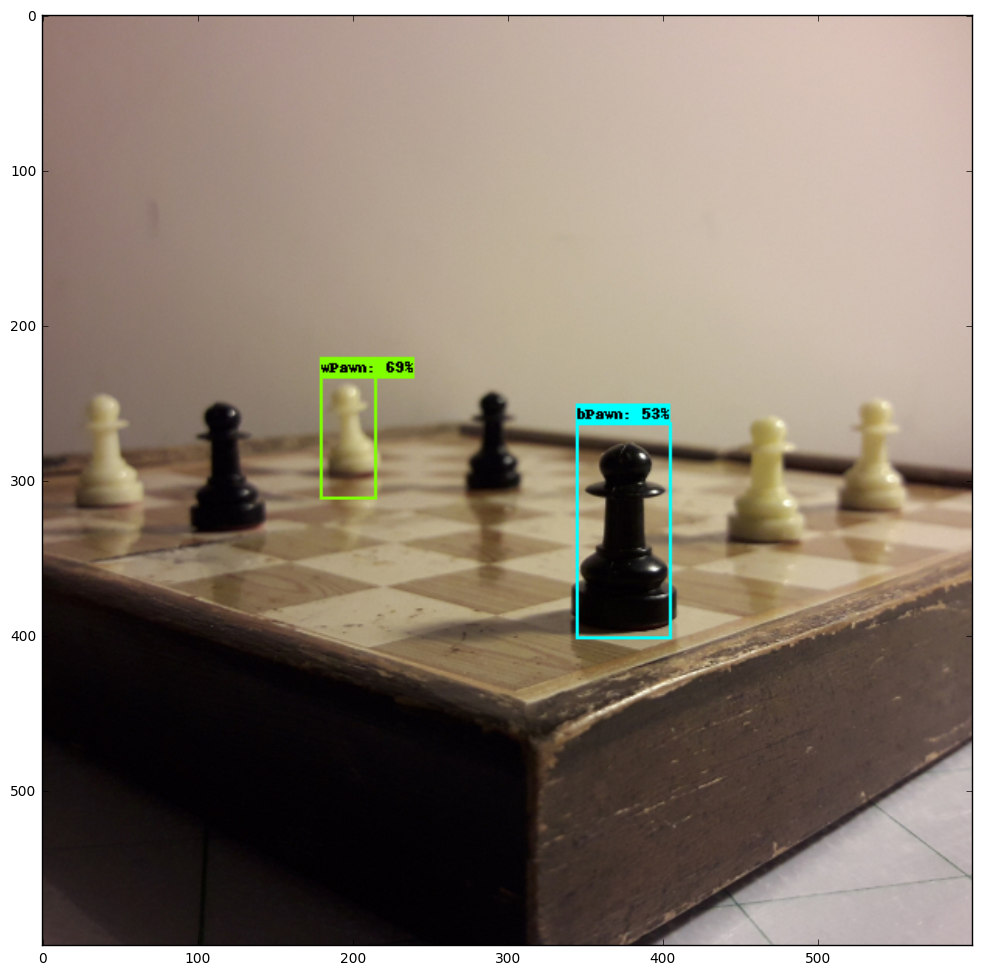

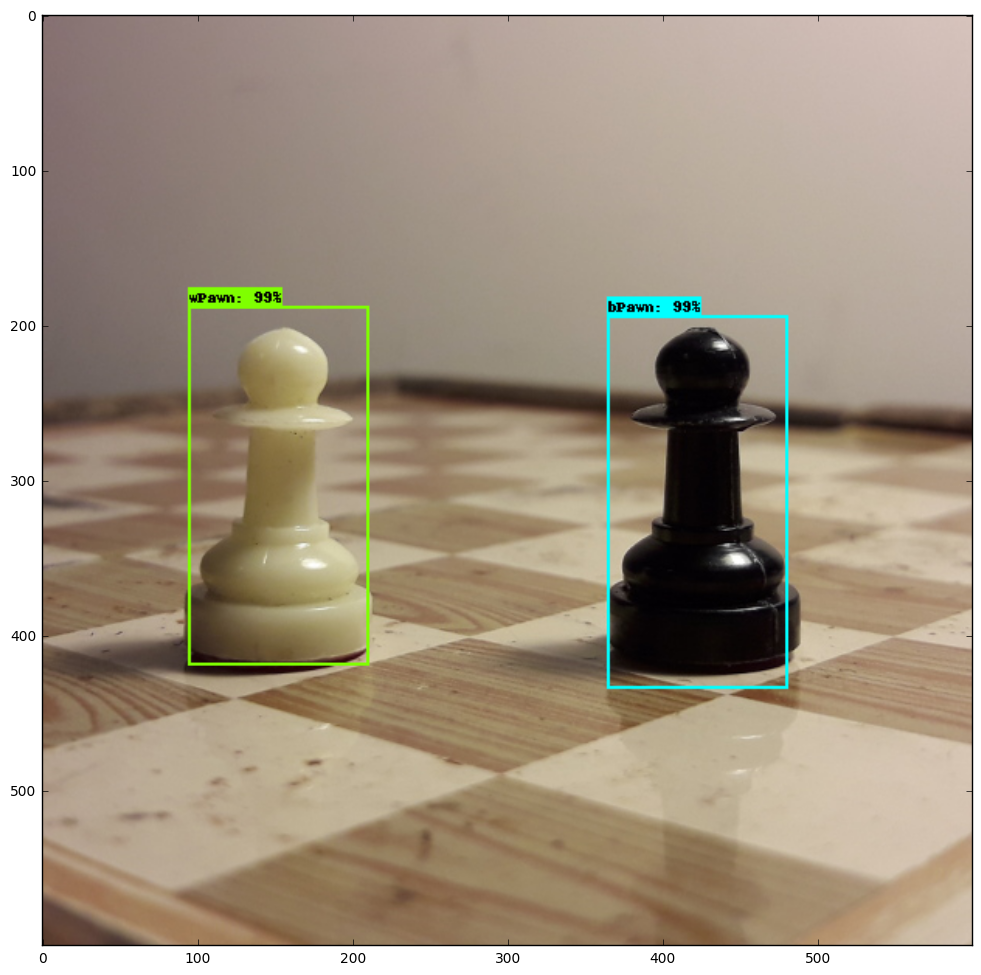

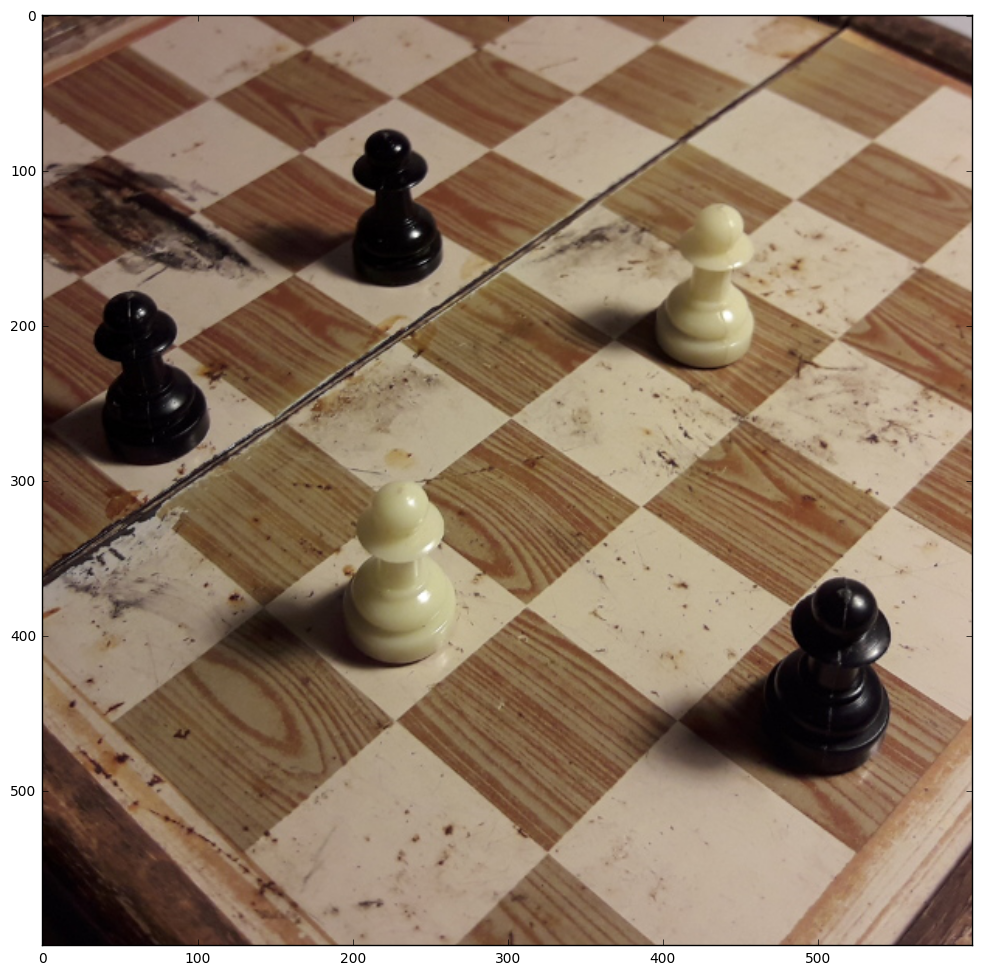

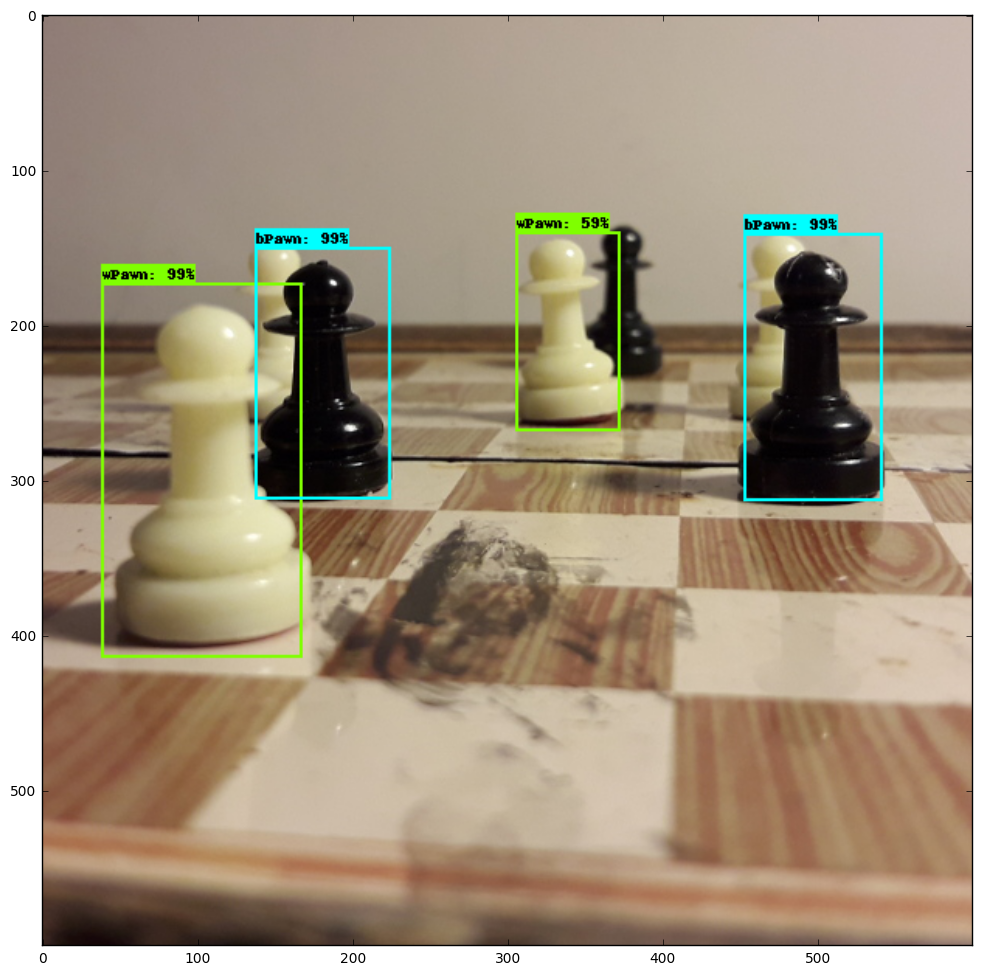

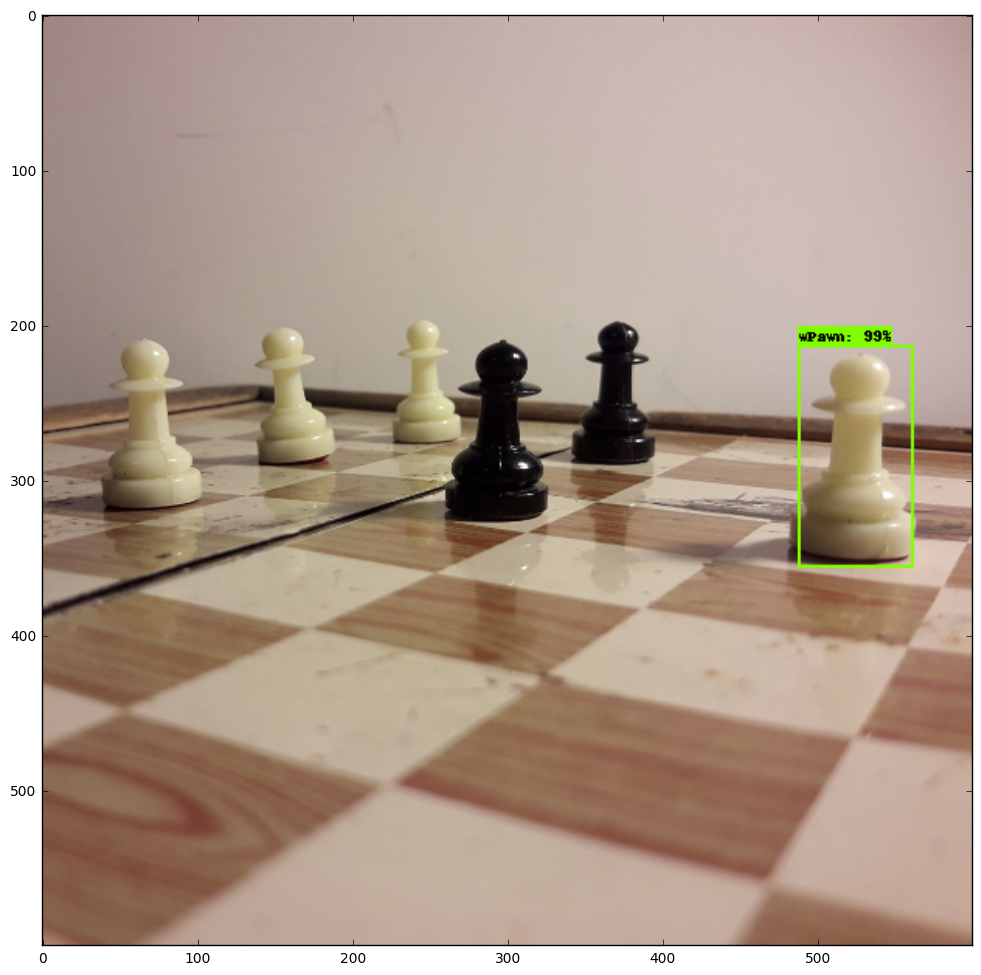

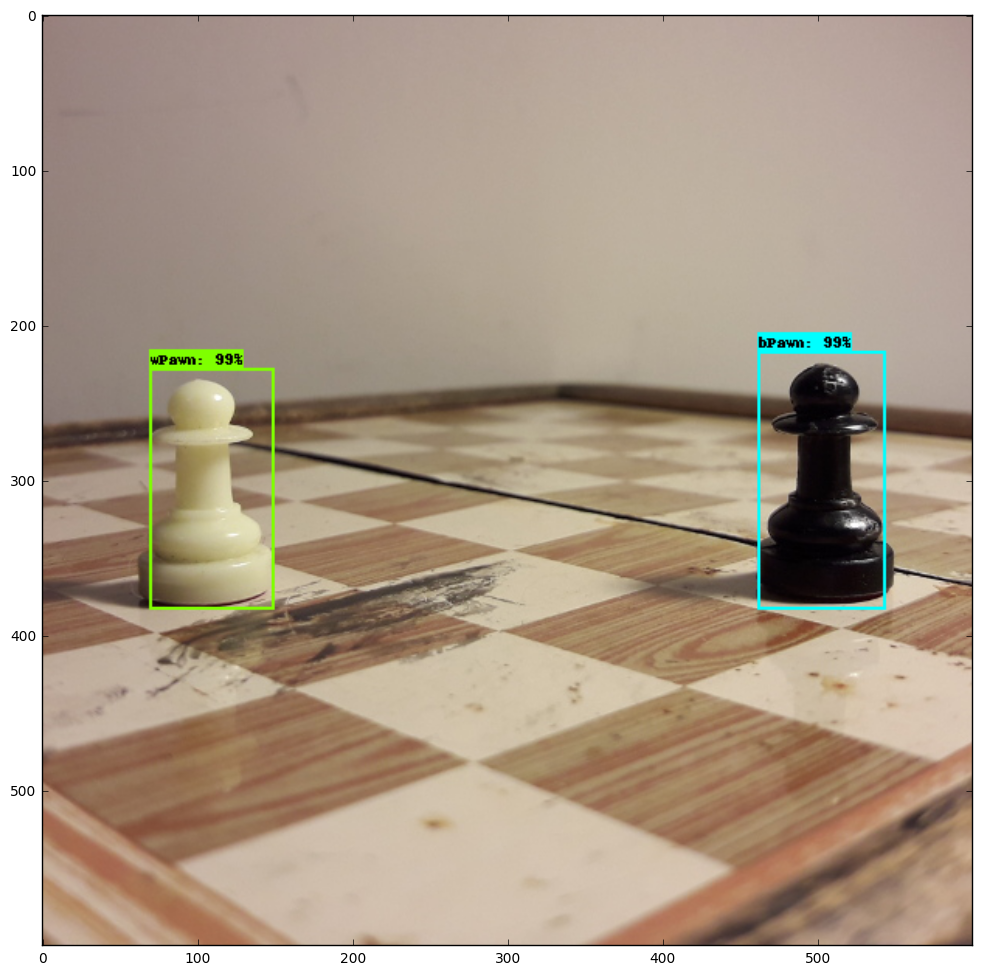

In [6]:
# Modified From API
# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=2)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)